In [31]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [3]:
dataDir='./COCOdatasettomato'
dataType='val'
annFile='{}/annotations/coco-{}.json'.format(dataDir,dataType)
# annFile='{}/annotations/coco.json'.format(dataDir)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[{'id': 1, 'name': 'Leaf', 'supercategory': 'background'}, {'id': 2, 'name': 'Leaf_Diseased', 'supercategory': 'background'}, {'id': 3, 'name': 'Background', 'supercategory': 'background'}]


Number of images containing all the  classes: 16


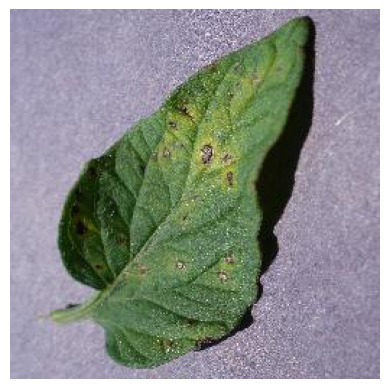

In [4]:


# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds() 
# Get all images containing the above Category IDs
# imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds()
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}/{}'.format(dataDir,'val',img['file_name']))/255.0
# I = io.imread('{}/images/{}'.format(dataDir,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

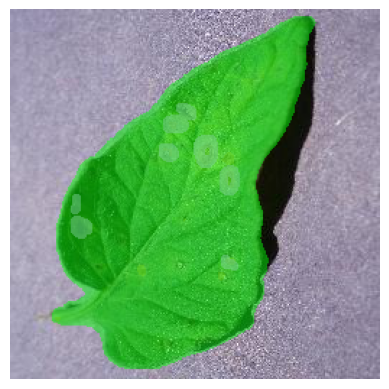

In [6]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [7]:

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(77, cats))

The class name is None


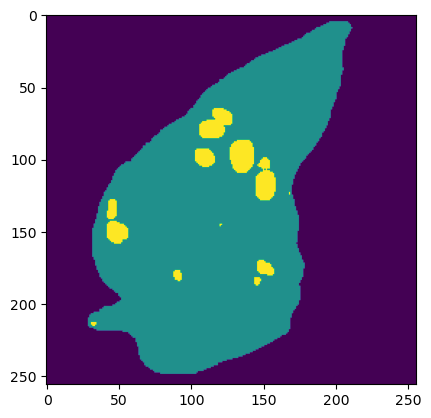

In [8]:

#### GENERATE A SEGMENTATION MASK ####
filterClasses = ['Leaf', 'Leaf_Diseased', 'Background']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

pt 2

In [9]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/coco-{}.json'.format(folder, mode)
    # annFile = '{}/annotations/coco.json'.format(folder)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [10]:
folder = './COCOdatasettomato'
# classes = ['laptop', 'tv', 'cell phone']
# classes = None
classes = ['Leaf', 'Leaf_Diseased', 'Background']
mode = 'val'

images, dataset_size, coco = filterDataset(folder, classes, mode)

print(images)
print(dataset_size)
print(coco)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[{'id': 13, 'width': 256, 'height': 256, 'file_name': 'image (9).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 7, 'width': 256, 'height': 256, 'file_name': 'image (614).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 2, 'width': 256, 'height': 256, 'file_name': 'image (174).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 5, 'width': 256, 'height': 256, 'file_name': 'image (282).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 16, 'width': 720, 'height': 540, 'file_name': 'tomatoes_002_full_width.jpg', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 6, 'width': 256, 'height': 256, 'file_name': 'image (47).JPG', 'lic

In [17]:
import segmentation_models as sm
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [18]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    # train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])
    train_img = preprocess_input(train_img)
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    # img_folder = '{}/images'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [19]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'normal'

val_gen = dataGeneratorCoco(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

In [20]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

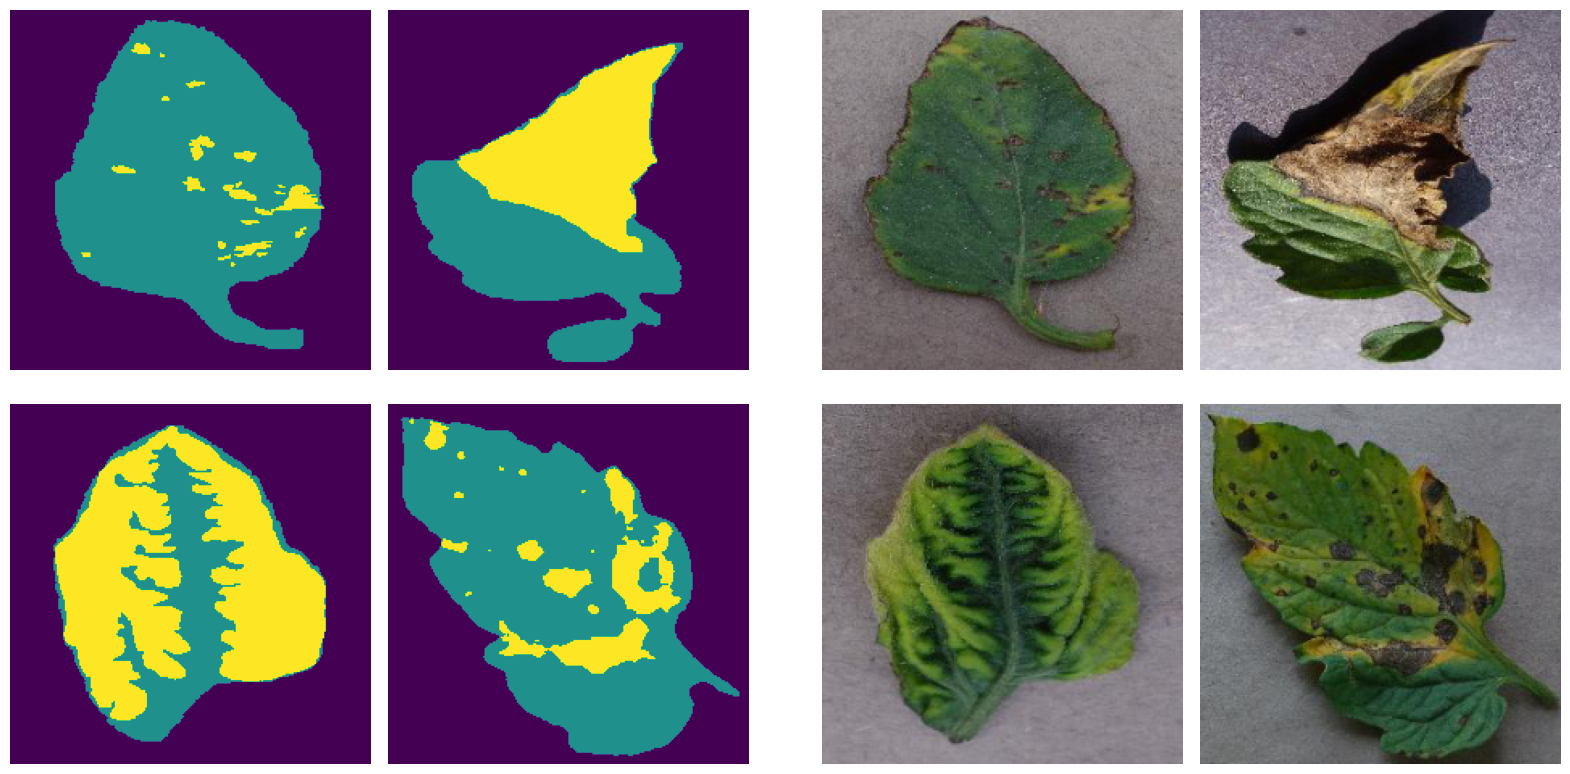

In [14]:
visualizeGenerator(val_gen)

In [21]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


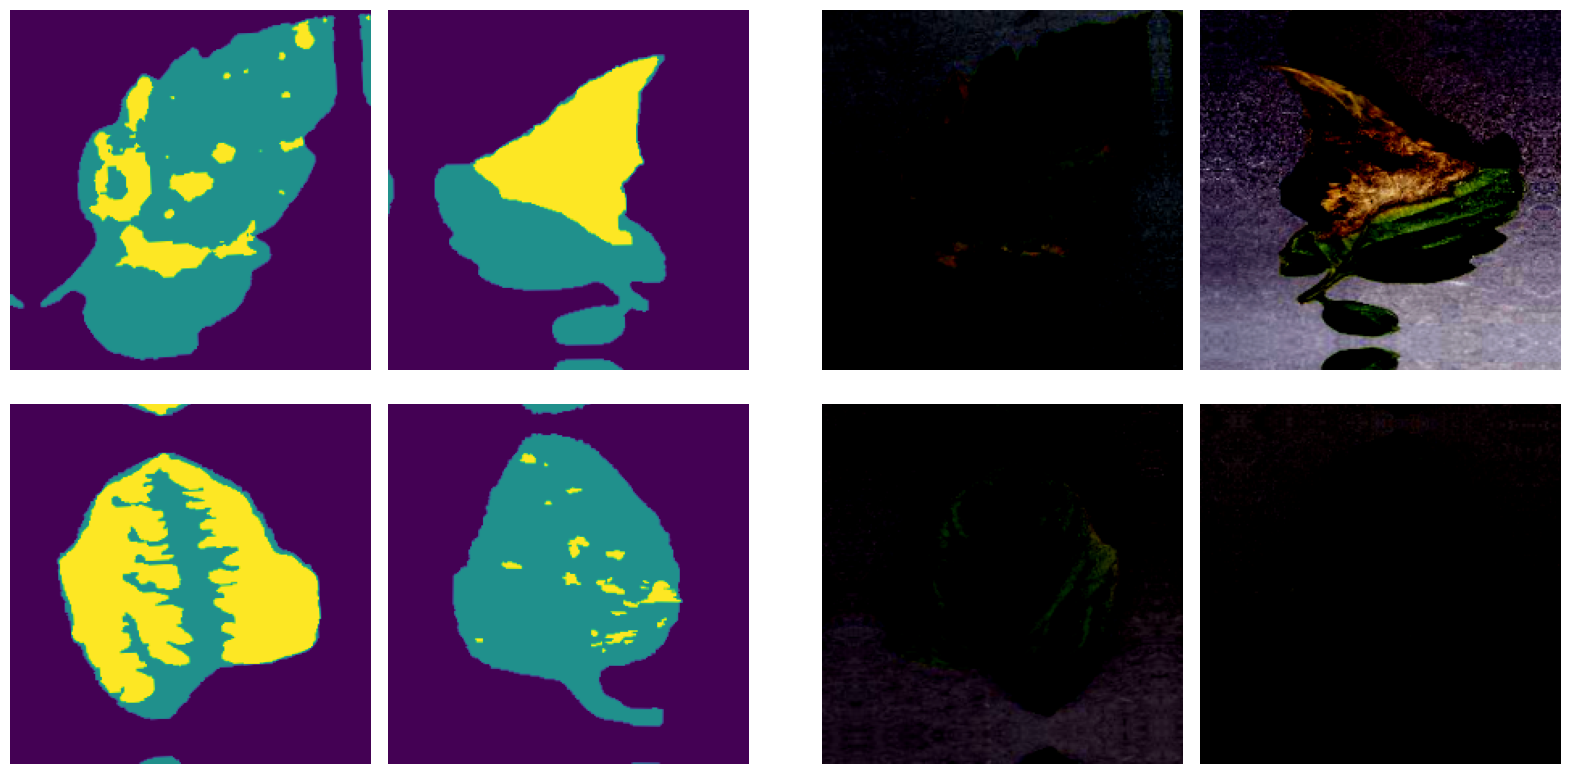

In [22]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

visualizeGenerator(aug_gen)

In [23]:
import tensorflow as tf

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


# print(sample_image.shape)
# model.predict(sample_image[tf.newaxis, ...])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
78
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
16


2023-03-13 12:08:49.527566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


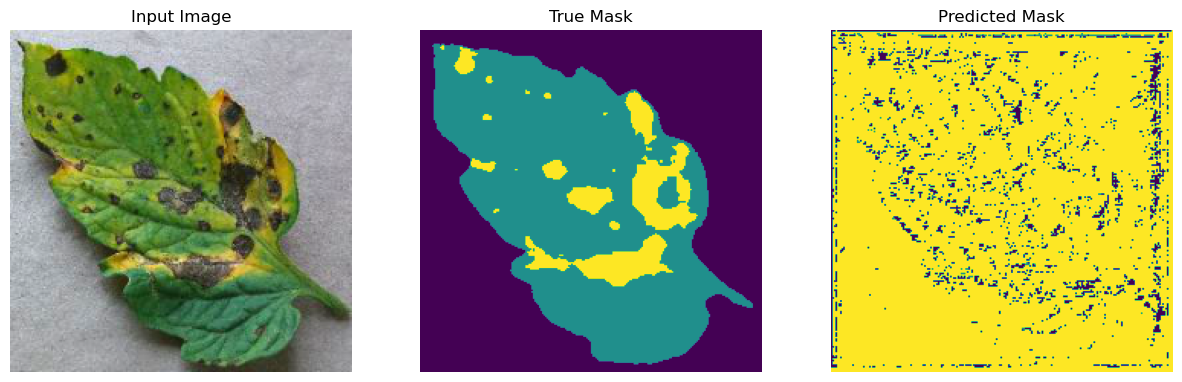

In [33]:
# -> Create filtered train dataset (using filterDataset()) 
train_images, train_size, train_coco = filterDataset(folder, classes=None, mode='train')
print(train_size)
# -> Create filtered val dataset (using filterDataset()) 
val_images, val_size, val_coco = filterDataset(folder, classes=None, mode='val')
print(val_size)
# images = np.array(images, dtype=object)
batch_size = 8
input_image_size = (224,224)
mask_type = 'normal'


# -> Create train generator (using dataGeneratorCoco()) 
mode = 'train'
train_gen = dataGeneratorCoco(train_images, classes, train_coco, folder,
                            input_image_size, batch_size, mode, mask_type)
# -> Create train generator (using dataGeneratorCoco()) 
mode = 'val'
val_gen = dataGeneratorCoco(val_images, classes, val_coco, folder,
                            input_image_size, batch_size, mode, mask_type)


# train_aug_gen = augmentationsGenerator(train_gen, augGeneratorArgs)
# val_aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

# print(sum(1 for _ in train_aug_gen))

n_epochs = 10

steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size


# import segmentation_models as sm
# BACKBONE = 'inceptionv3'
# preprocess_input = sm.get_preprocessing(BACKBONE)

# x_train = preprocess_input(x_train)
# x_val = preprocess_input(x_val)



model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=3, activation='softmax')
model.compile('Adam', loss=sm.losses.CategoricalFocalLoss() , metrics=[sm.metrics.iou_score])

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

img, mask = next(val_gen)
sample_image = img[0]
sample_mask = mask[0]
show_predictions()



1/1 [==============================] - 0s 80ms/step


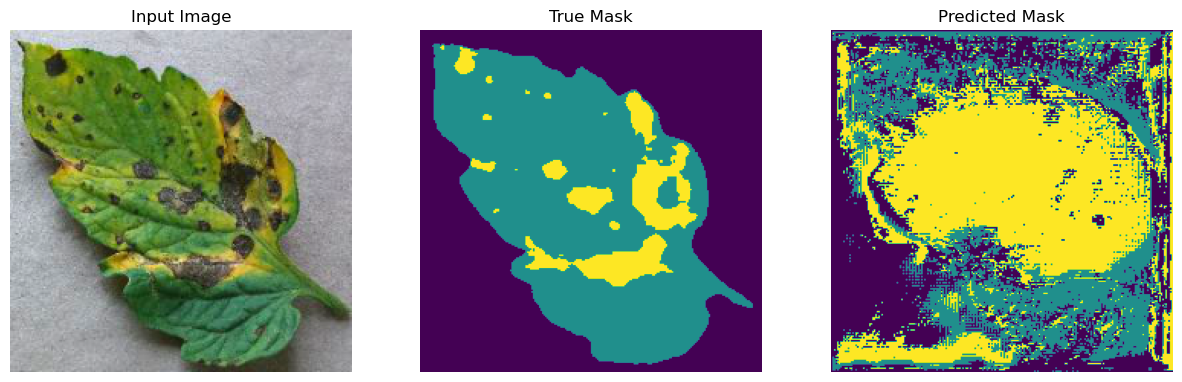


Sample Prediction after epoch 10

9/9 [==============================] - 5s 566ms/step - loss: 0.1281 - iou_score: 0.3348 - val_loss: 0.0793 - val_iou_score: 0.2423


In [34]:
# Start the training process
history = model.fit(x = train_gen,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose = True,
                callbacks=[DisplayCallback()])